## Data Preparation

In [115]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import date
from datetime import datetime, timedelta
import math
import matplotlib.pyplot as plt

import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.models import load_model, Model
from keras.layers import Dense, Dropout, Activation, Input, LSTM, Reshape, Dense, SimpleRNN, GRU, LSTM, Dropout
from tensorflow.keras.optimizers import SGD

from keras.utils import np_utils
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
df = yf.download("PFE", start="2013-01-01", end=date.today())

[*********************100%***********************]  1 of 1 completed


In [3]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-02,24.222012,24.582542,24.032257,24.582542,17.744638,35332399
2013-01-03,24.648956,24.658443,24.250475,24.525618,17.703543,35580300
2013-01-04,24.525618,24.658443,24.440228,24.629980,17.778883,30149565
2013-01-07,24.582542,24.715370,24.449715,24.648956,17.792576,27172015
2013-01-08,24.667933,24.905123,24.648956,24.686907,17.819975,32734078
...,...,...,...,...,...,...
2021-11-22,50.950001,51.470001,50.380001,51.200001,51.200001,27287900
2021-11-23,50.580002,51.450001,50.299999,51.080002,51.080002,24946200
2021-11-24,51.180000,51.330002,50.709999,50.889999,50.889999,18556800


In [26]:
close = df["Close"]

In [52]:
# create training and test set
train = close[:'2018'].values
test  = close['2019':].values

# scale the data
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(np.array(train).reshape(-1,1))
test_scaled = sc.fit_transform(np.array(test).reshape(-1,1))

In [53]:
def prepare_data(time_steps):
    '''
    input: 
      data: dataframe with dates and price data
    output:
      X_train, y_train: data from 2013/1/1-2018/12/31
      X_test:  data from 2019 -
      sc:      insantiated MinMaxScaler object fit to the training data
    '''

    # create training data of s samples and t time steps
    X_train = []
    y_train = []
    for i in range(time_steps, len(train) - 1): 
        X_train.append(train_scaled[i - time_steps: i, 0])
        y_train.append(train_scaled[i: i + 1, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshaping X_train for efficient modelling
    X_train = np.reshape(X_train, 
                        (X_train.shape[0],X_train.shape[1], 1) )

    test_inputs = close.values[len(close) - len(test) - time_steps:].reshape(-1, 1)
    test_inputs_scaled = sc.transform(test_inputs)
    
    # Preparing X_test
    X_test = []
    # 5 - (734 + 5 - 1)
    for i in range(time_steps, len(test) + time_steps):
        X_test.append(test_inputs_scaled[i - time_steps: i, 0])
        
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1) )

    return X_train, y_train , X_test, sc

In [54]:
# We use a 5 past-day window
X_train, y_train, X_test, sc = prepare_data(5)

## Model Construction

In [55]:
model = keras.Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
#my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
#my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
model.add(LSTM(units=50, activation='tanh'))
model.add(Dropout(0.4))
model.add(Dense(units=1))

In [56]:
model.compile(optimizer=SGD(learning_rate=0.01, 
                            decay=1e-7, 
                            momentum=0.9, 
                            nesterov=False),
                loss='mean_squared_error')

In [57]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 5, 50)             10400     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [58]:
model.fit(X_train, y_train, epochs=50, batch_size=150, verbose=1)

Epoch 1/50
11/11 [==============================] - 3s 9ms/step - loss: 0.0849
Epoch 2/50
11/11 [==============================] - 0s 8ms/step - loss: 0.0577
Epoch 3/50
11/11 [==============================] - 0s 9ms/step - loss: 0.0340
Epoch 4/50
11/11 [==============================] - 0s 9ms/step - loss: 0.0312
Epoch 5/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0284
Epoch 6/50
11/11 [==============================] - 0s 7ms/step - loss: 0.0273
Epoch 7/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0255
Epoch 8/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0242
Epoch 9/50
11/11 [==============================] - 0s 7ms/step - loss: 0.0234
Epoch 10/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0219
Epoch 11/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0208
Epoch 12/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0193
Epoch 13/50
11/11 [==============================

In [59]:
train_predict = sc.inverse_transform(model.predict(X_train))
test_predict = sc.inverse_transform(model.predict(X_test))

In [60]:
math.sqrt(mean_squared_error(y_train, train_predict))

36.661155884079776

In [68]:
def plot_graphs(X_test, model_predict):
    X = df["2019":].index[:-1]
    plt.plot(X, sc.inverse_transform(X_test[:-1, 0]), label='True')
    plt.plot(X, model_predict, label='Prediction')
    
    plt.legend()

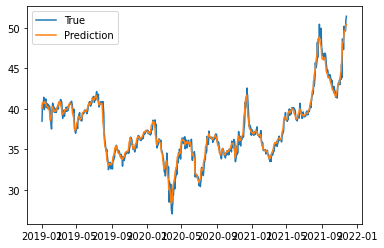

In [69]:
plot_graphs(X_test, test_predict[:-1])

## Predicton

In [70]:
X_train.shape

(1504, 5, 1)

In [71]:
len(test)

734

In [82]:
x_input = test_scaled[729:].reshape(1,-1)
x_input = x_input.reshape((1,5,1))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[0.88689184]]


In [83]:
from numpy import array

today = date.today()
d1 = date(2022, 3, 1)

n_steps = 5

for i in range((d1 - today).days + 1):
    
    if(len(temp_input) > 5):
#         print(temp_input)
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
#         print(x_input.shape)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        
        #print(temp_input)
        lst_output.extend(yhat.tolist())
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
#         print(yhat[0])
        temp_input.extend(yhat[0].tolist())
#         print(len(temp_input))
        lst_output.extend(yhat.tolist())
    

print(lst_output)


1 day input [0.89173017 0.88468512 1.         0.94067409 0.88689184]
1 day output [[0.8919283]]
2 day input [0.88468512 1.         0.94067409 0.88689184 0.89192832]
2 day output [[0.8950148]]
3 day input [1.         0.94067409 0.88689184 0.89192832 0.89501482]
3 day output [[0.8977242]]
4 day input [0.94067409 0.88689184 0.89192832 0.89501482 0.89772421]
4 day output [[0.875485]]
5 day input [0.88689184 0.89192832 0.89501482 0.89772421 0.875485  ]
5 day output [[0.8637671]]
6 day input [0.89192832 0.89501482 0.89772421 0.875485   0.86376709]
6 day output [[0.8612008]]
7 day input [0.89501482 0.89772421 0.875485   0.86376709 0.86120081]
7 day output [[0.8558558]]
8 day input [0.89772421 0.875485   0.86376709 0.86120081 0.85585582]
8 day output [[0.8483782]]
9 day input [0.875485   0.86376709 0.86120081 0.85585582 0.84837818]
9 day output [[0.8388815]]
10 day input [0.86376709 0.86120081 0.85585582 0.84837818 0.83888149]
10 day output [[0.8324939]]
11 day input [0.86120081 0.85585582 0.8

87 day output [[0.5881622]]
88 day input [0.59454978 0.59291995 0.59131265 0.58972681 0.58816218]
88 day output [[0.58661854]]
89 day input [0.59291995 0.59131265 0.58972681 0.58816218 0.58661854]
89 day output [[0.58509535]]
90 day input [0.59131265 0.58972681 0.58816218 0.58661854 0.58509535]
90 day output [[0.5835924]]
91 day input [0.58972681 0.58816218 0.58661854 0.58509535 0.58359241]
91 day output [[0.5821092]]
[[0.8868918418884277], [0.8919283151626587], [0.8950148224830627], [0.8977242112159729], [0.8754850029945374], [0.8637670874595642], [0.8612008094787598], [0.8558558225631714], [0.8483781814575195], [0.8388814926147461], [0.8324939012527466], [0.8270491361618042], [0.8207376003265381], [0.8142015337944031], [0.8079076409339905], [0.8023009300231934], [0.7967705130577087], [0.7911639213562012], [0.7856957912445068], [0.7804402112960815], [0.775375485420227], [0.7703880667686462], [0.765491247177124], [0.7607269883155823], [0.7560909986495972], [0.7515633702278137], [0.7471

In [ ]:
close.values

In [118]:
base = datetime.today()
date_list = [base + timedelta(days=x) for x in range(91)]
date_list

[datetime.datetime(2021, 11, 30, 20, 33, 3, 91019),
 datetime.datetime(2021, 12, 1, 20, 33, 3, 91019),
 datetime.datetime(2021, 12, 2, 20, 33, 3, 91019),
 datetime.datetime(2021, 12, 3, 20, 33, 3, 91019),
 datetime.datetime(2021, 12, 4, 20, 33, 3, 91019),
 datetime.datetime(2021, 12, 5, 20, 33, 3, 91019),
 datetime.datetime(2021, 12, 6, 20, 33, 3, 91019),
 datetime.datetime(2021, 12, 7, 20, 33, 3, 91019),
 datetime.datetime(2021, 12, 8, 20, 33, 3, 91019),
 datetime.datetime(2021, 12, 9, 20, 33, 3, 91019),
 datetime.datetime(2021, 12, 10, 20, 33, 3, 91019),
 datetime.datetime(2021, 12, 11, 20, 33, 3, 91019),
 datetime.datetime(2021, 12, 12, 20, 33, 3, 91019),
 datetime.datetime(2021, 12, 13, 20, 33, 3, 91019),
 datetime.datetime(2021, 12, 14, 20, 33, 3, 91019),
 datetime.datetime(2021, 12, 15, 20, 33, 3, 91019),
 datetime.datetime(2021, 12, 16, 20, 33, 3, 91019),
 datetime.datetime(2021, 12, 17, 20, 33, 3, 91019),
 datetime.datetime(2021, 12, 18, 20, 33, 3, 91019),
 datetime.datetime(20

<Figure size 720x1440 with 0 Axes>

2021-11-29


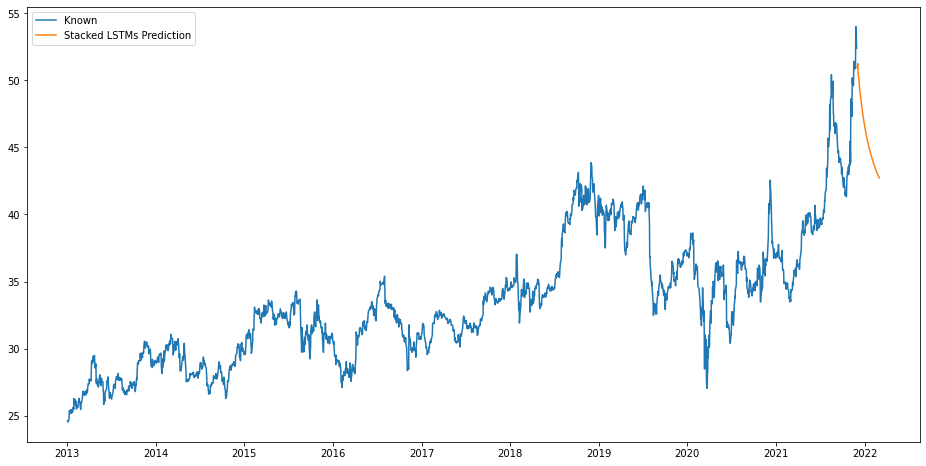

In [135]:
day_new=np.arange(1,len(close.values)+1)
day_pred=np.arange(len(close.values),len(close.values)+92)
print(df.index[-1].date())
d1 = date(2022, 3, 1).strftime("%Y-%m-%d")
dates = []

for i in range(len(df.index)):
    dates.append(df.index[i].date())

base = datetime.today()
futureDates =  [base + timedelta(days=x) for x in range(92)]

plt_1 = plt.figure(figsize=(16, 8))
plt.plot(dates, close.values, label='Known')
plt.plot(futureDates, sc.inverse_transform(lst_output), label='Stacked LSTMs Prediction')
plt.legend()